# Segment seeds in images

I am not an image processing expert so I had to search for an image processing pipeline that works for segmenting these low contrast images. This is almost certainly not the most efficient method for segmenting the seeds.

## Setup

In [1]:
import math
from collections import namedtuple
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from skimage import (
    color,
    draw,
    exposure,
    filters,
    io,
    measure,
    morphology,
    segmentation,
    transform,
    util,
)
from skimage.filters import rank

You will need to change this location.

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"
SEED_DIR = Path(".") / "data" / "seed_images"

In [3]:
SUFFIXES = (".jpeg", ".jpg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in SUFFIXES]

## Display an image

In [4]:
def one_up(image):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis("off")
    plt.show()

## Display a before & an after manipulation pair of images

In [5]:
def two_up(input_image, output_image, output_title):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 8)
    )
    ax = axes.ravel()

    ax[0].imshow(input_image, cmap=plt.cm.gray)
    ax[0].set_title("before")
    ax[0].axis("off")

    ax[1].imshow(output_image, cmap=plt.cm.gray)
    ax[1].set_title(output_title)
    ax[1].axis("off")

    plt.show()
    return output_image

## Get initial gray scale image

In [6]:
def get_gray_scale(image_path):
    orig = io.imread(image_path)
    gray = np.uint8(color.rgb2gray(orig) * 255.0)
    return orig, gray

## Get a mask for the image

I don't want to perform image manipulations on the black regions of the image. Using this mask is important (autolevel_percentile needs it), however it introduces its own complications later on.

Remove the watermark on the lower right corner. It will interfere with the image manipulations.

In [7]:
def get_mask(gray, watermark_coords=(750, 1100)):
    threshold = filters.threshold_otsu(gray)
    mask = gray > threshold

    mask = morphology.remove_small_objects(mask, 64)
    mask = morphology.remove_small_holes(mask, 64)

    rr, cc = draw.rectangle(watermark_coords, mask.shape, shape=mask.shape)
    mask[rr, cc] = 0

    return mask

In [8]:
def enhance_contrast(image, mask, disk=50, low=0.2, high=0.8):
    image = rank.autolevel_percentile(
        image, footprint=morphology.disk(disk), p0=low, p1=high, mask=mask
    )
    return image

In [9]:
Circle = namedtuple("Circle", "x y radius")

In [10]:
def find_circles(mask, edge_threshold=0.2, small=75, large=500, count=2):
    edges = filters.sobel(mask)
    edges = edges > edge_threshold

    hough_radii = np.arange(small, large, 4)
    hough_res = transform.hough_circle(edges, hough_radii)

    # Select the most prominent circles
    accums, cx, cy, radii = transform.hough_circle_peaks(
        hough_res, hough_radii, total_num_peaks=count
    )

    circles = [Circle(y=y, x=x, radius=r) for y, x, r in zip(cy, cx, radii)]
    circles = sorted(circles, key=lambda c: -c.radius)
    return edges, circles

In [11]:
def expand_circle(edges, circle, start, stop, new_value=128):
    edges = edges.copy()
    for radius in range(start, stop):
        circy, circx = draw.circle_perimeter(
            circle.y, circle.x, radius, shape=edges.shape
        )
        edges[circy, circx] = new_value
    return edges

In [12]:
def flood_fill(edges, seed_point=(1, 1), new_value=128):
    edges = segmentation.flood_fill(edges, seed_point, new_value)
    return edges

In [13]:
def threshold_otsu(image, mask):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = binary & mask
    return binary

In [14]:
def apply_mask(image, edges, area_threshold=32, new_value=128):
    image = image.copy()
    image[edges] = new_value
    image = morphology.remove_small_holes(image, area_threshold=area_threshold)
    image = util.invert(image)
    return image

In [15]:
def find_areas(image):
    labels = measure.label(image)
    overlay = color.label2rgb(labels, image, bg_label=0, bg_color=None)
    return overlay, labels

In [16]:
Orient = namedtuple("Orient", "cos_para sin_para cos_perp sin_perp")

In [17]:
def get_orientation(body):
    # Start with the centroid calculated by scikit's measure.label function
    centroid_rr, centroid_cc = int(body.centroid[0]), int(body.centroid[1])

    # Pre-calculate some orientation parameters
    cos_para = math.cos(body.orientation)  # parallel
    sin_para = math.sin(body.orientation)

    cos_perp = math.cos(body.orientation + math.pi / 2)  # perpendicular
    sin_perp = math.sin(body.orientation + math.pi / 2)

    return Orient(cos_para, sin_para, cos_perp, sin_perp)

In [18]:
@dataclass
class Seed:
    dir: int = 0
    path: str | Path | None = None
    head: Any | None = None
    body: Any | None = None
    image: Any | None = None

In [19]:
def find_head(
    input_image,
    image_path,
    labels,
    body,
    body_threshold=8_000,
    head_search_height=300,
    head_axis_ratio=3.0,
):
    # Start with the centroid calculated by scikit's measure.label function
    centroid_rr, centroid_cc = int(body.centroid[0]), int(body.centroid[1])
    ori = get_orientation(body)

    # Draw a line segment from the centroid along the orientation, both ways
    for dir_ in [-1, 1]:
        point_rr = int(centroid_rr + dir_ * head_search_height * ori.cos_para)
        point_cc = int(centroid_cc + dir_ * head_search_height * ori.sin_para)

        line_rr, line_cc = draw.line(centroid_rr, centroid_cc, point_rr, point_cc)

        # Find an area that intersects this line
        for head in measure.regionprops(labels):
            if head.area >= body_threshold:
                continue

            # Not a head shape
            if head.axis_major_length > head_axis_ratio * head.axis_minor_length:
                continue

            # Check intersection
            tt, ll, bb, rr = head.bbox

            line = np.zeros(input_image.shape[:-1], dtype=bool)
            line[line_rr, line_cc] = 1  # (1, 1, 1)
            line = line[tt:bb, ll:rr]

            # Does not intersect with the line so it's not for this body
            if not (head.image & line).any():
                continue

            # Looks good return a Seed
            seed_image = np.zeros(input_image.shape[:-1], dtype=bool)

            tt, ll, bb, rr = body.bbox
            seed_image[tt:bb, ll:rr] = body.image

            tt, ll, bb, rr = head.bbox
            seed_image[tt:bb, ll:rr] = head.image

            return Seed(
                dir=dir_, path=image_path, head=head, body=body, image=seed_image
            )

    # No head found, assume it is attached or missing
    else:
        seed_image = np.zeros(input_image.shape[:-1], dtype=bool)

        tt, ll, bb, rr = body.bbox
        seed_image[tt:bb, ll:rr] = body.image

        return Seed(path=image_path, body=body, image=seed_image)

In [20]:
def attach_head(seed: Seed, belt_search_radius=40, head_search_height=300):
    if not seed.head:
        return

    # Start with the centroid calculated by scikit's measure.label function
    centroid_rr, centroid_cc = int(seed.body.centroid[0]), int(seed.body.centroid[1])
    ori = get_orientation(seed.body)

    # Get the points of the belt of the seed, which extends from the centroid
    # to the outer most points of the seed perpendicular to the seed's orientation

    # Draw the 1st half belt
    rr = int(centroid_rr + belt_search_radius * ori.cos_perp * seed.dir)
    cc = int(centroid_cc + belt_search_radius * ori.sin_perp * seed.dir)
    belt1_rr, belt1_cc = draw.line(rr, cc, centroid_rr, centroid_cc)

    # Trim the 1st half belt
    idx = np.argwhere(seed.image[belt1_rr, belt1_cc])
    belt1_rr = int(belt1_rr[idx[0][0]])
    belt1_cc = int(belt1_cc[idx[0][0]])

    # Draw the 2nd half belt
    rr = int(centroid_rr - belt_search_radius * ori.cos_perp * seed.dir)
    cc = int(centroid_cc - belt_search_radius * ori.sin_perp * seed.dir)
    belt2_rr, belt2_cc = draw.line(rr, cc, centroid_rr, centroid_cc)

    # Trim the 2nd half belt
    idx = np.argwhere(seed.image[belt2_rr, belt2_cc])
    belt2_rr = int(belt2_rr[idx[0][0]])
    belt2_cc = int(belt2_cc[idx[0][0]])

    # Scan for the top of the head
    for i in range(head_search_height, -1, -1):
        delta_rr = centroid_rr - int(centroid_rr - i * ori.cos_para * seed.dir)
        delta_cc = centroid_cc - int(centroid_cc - i * ori.sin_para * seed.dir)

        rr1 = belt1_rr + delta_rr
        cc1 = belt1_cc + delta_cc
        rr2 = belt2_rr + delta_rr
        cc2 = belt2_cc + delta_cc

        line_rr, line_cc = draw.line(rr1, cc1, rr2, cc2)

        # Check if the line intersects the head
        tt, ll, bb, rr = seed.head.bbox
        line = np.zeros(seed.image.shape, dtype=bool)
        line[line_rr, line_cc] = 1
        head_part = line[tt:bb, ll:rr]

        if not (seed.head.image & head_part).any():
            continue

        poly_rr, poly_cc = draw.polygon(
            (rr1, rr2, belt2_rr, belt1_rr),
            (cc1, cc2, belt2_cc, belt1_cc),
        )
        seed.image[poly_rr, poly_cc] = 1

        break

## 

In [21]:
def join_head_body(
    input_image,
    image_path,
    labels,
    body_threshold=5500,
    head_search_height=300,
    head_axis_ratio=3.0,
):
    seeds = []
    head_search_radii = list(range(-20, 21))

    input_image = input_image.copy()

    # Find head for each body if there is one
    for body in measure.regionprops(labels):
        if body.area < body_threshold:
            continue

        seed = find_head(
            input_image, image_path, labels, body, body_threshold, head_search_height
        )
        attach_head(seed)
        seeds.append(seed)

    return seeds

In [27]:
def sort_seeds(seeds):
    seeds = sorted(seeds, key=lambda s: -s.body.centroid[1])
    seeds[1:] = sorted(seeds[1:], key=lambda s: s.body.centroid[0])
    return seeds

In [28]:
def cutout_seeds(seeds, gray):
    for i, seed in enumerate(seeds):
        image, labels = find_areas(seed.image)
        for props in measure.regionprops(labels):
            tt, ll, bb, rr = props.bbox
            area = gray[tt:bb, ll:rr].copy()
            area *= props.image_convex

            one_up(area)
            path = SEED_DIR / f"{seed.path.stem}_{i}.{seed.path.suffix}"
            io.imsave(path, area)

## Segment seeds

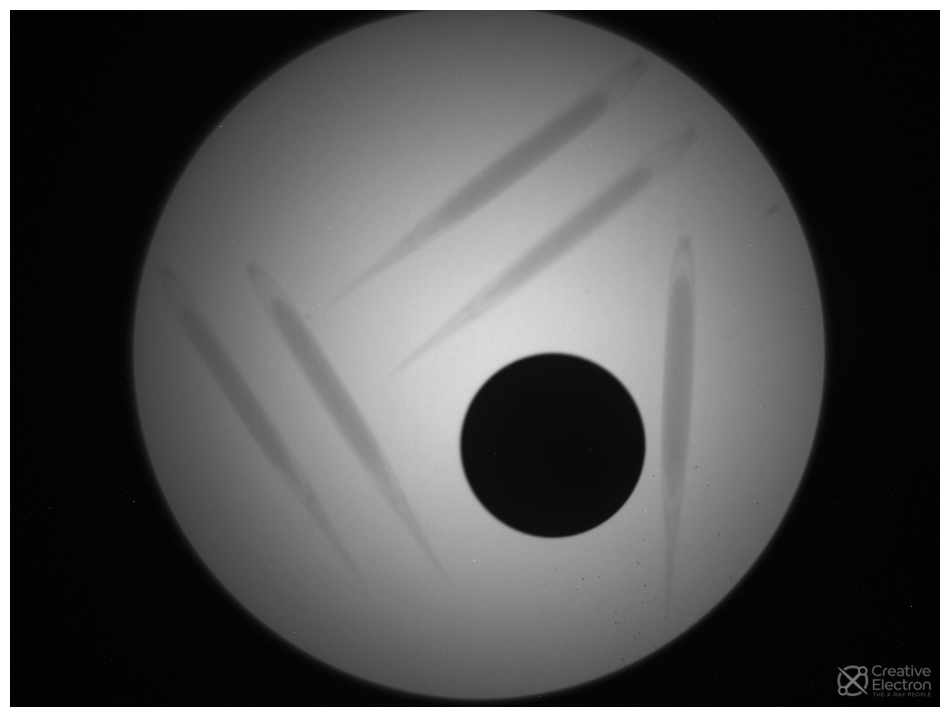

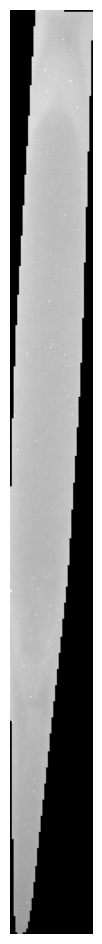

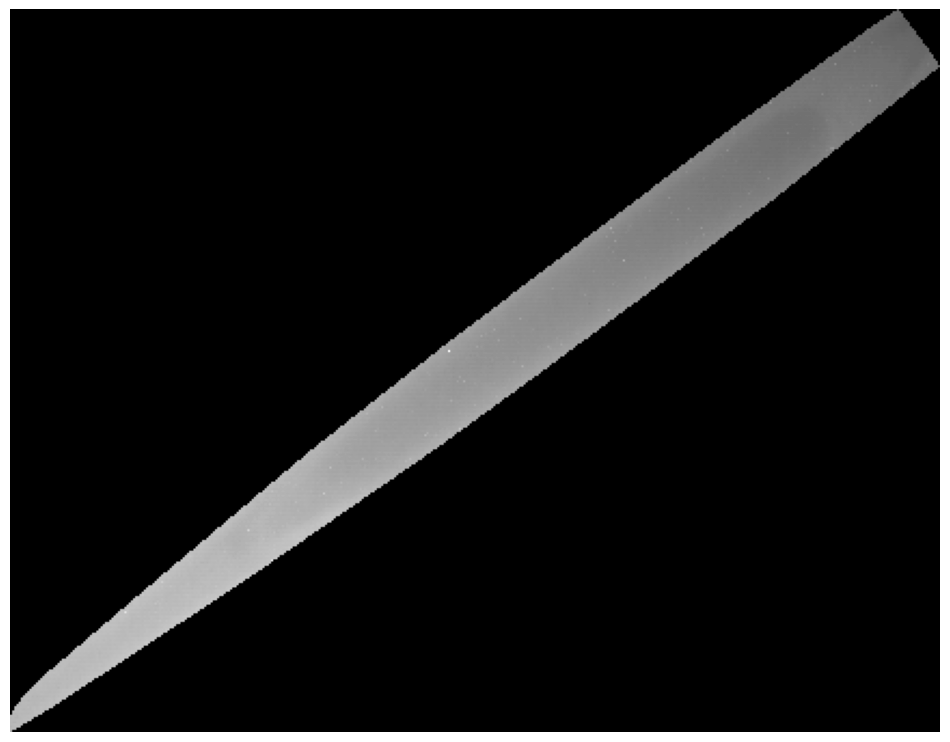

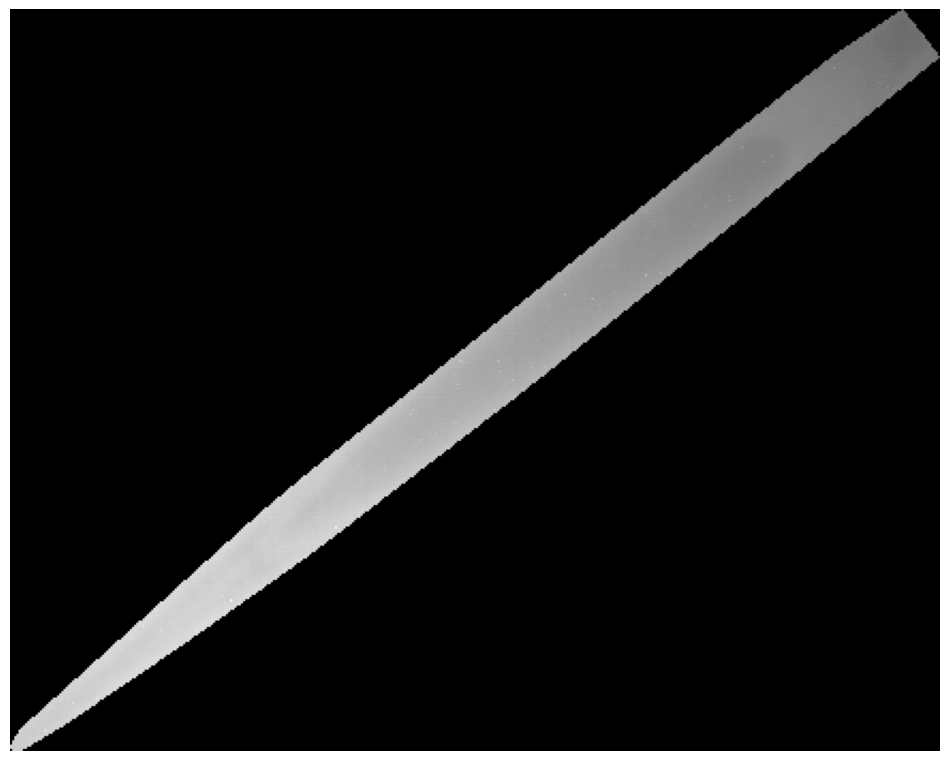

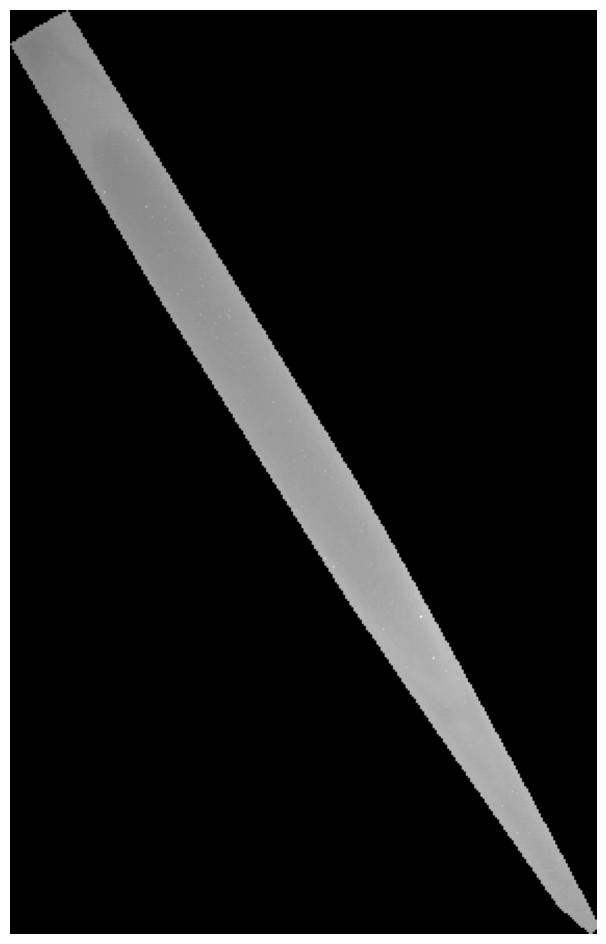

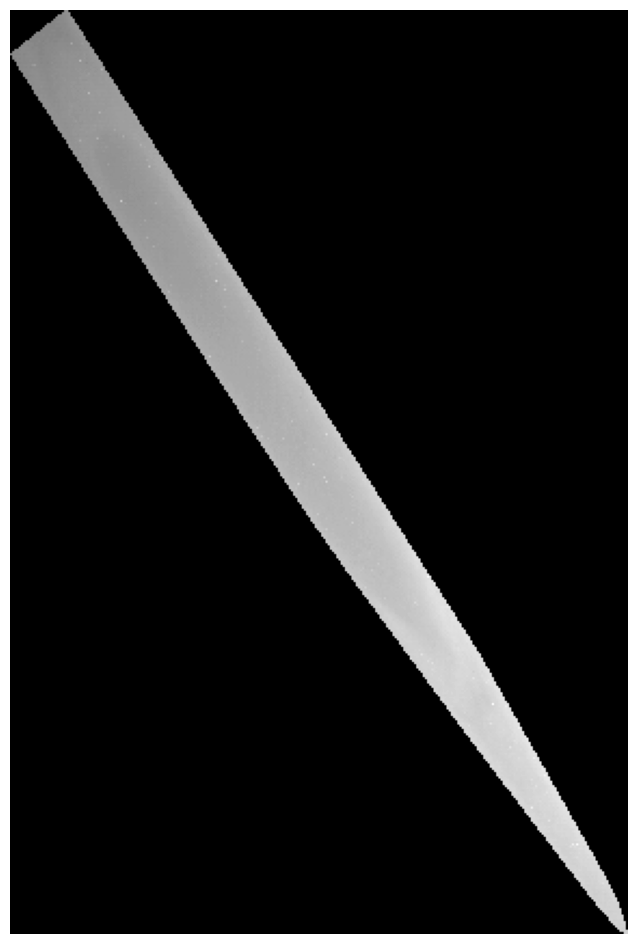

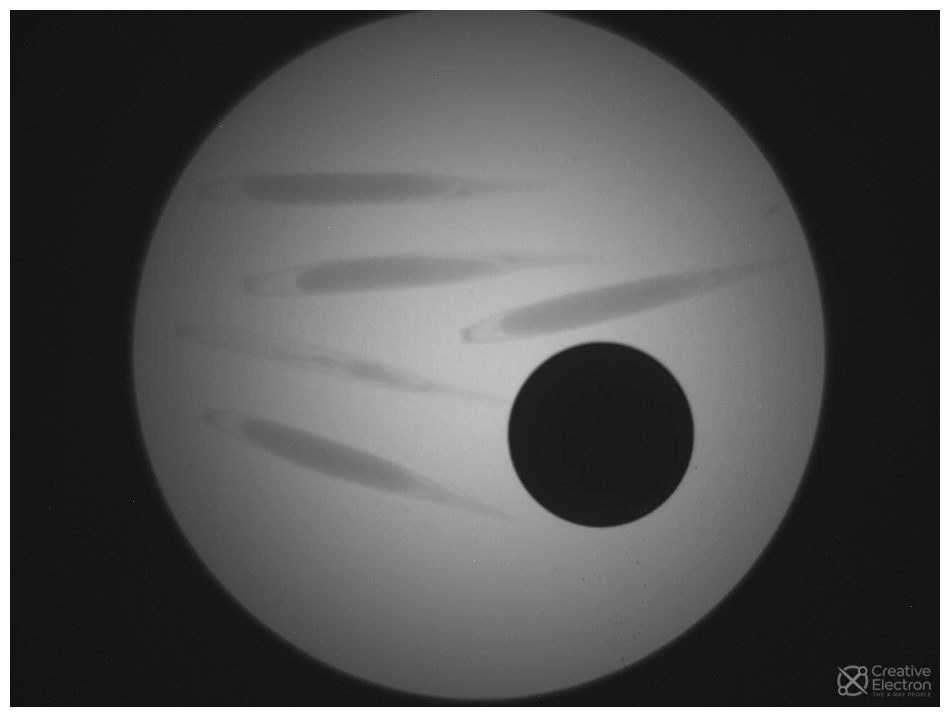

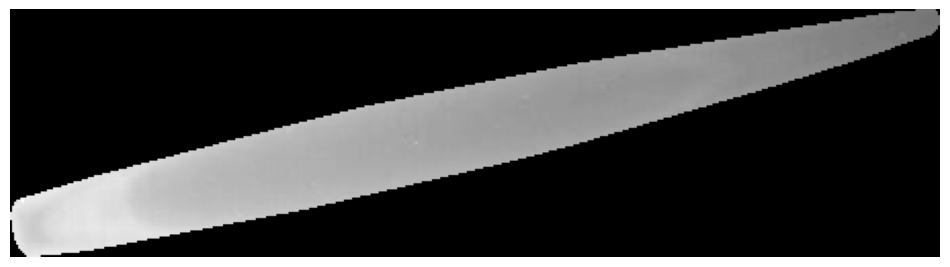

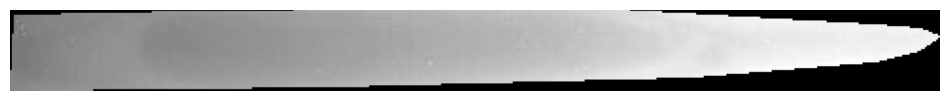

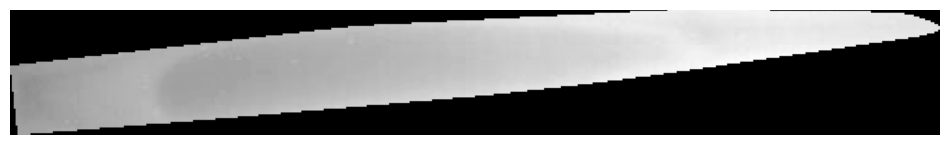

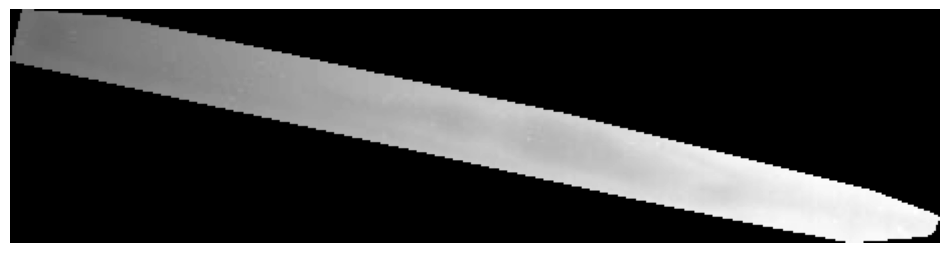

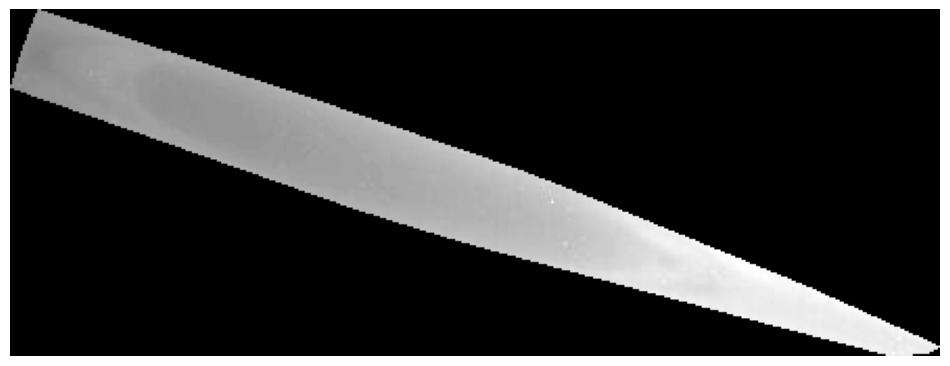

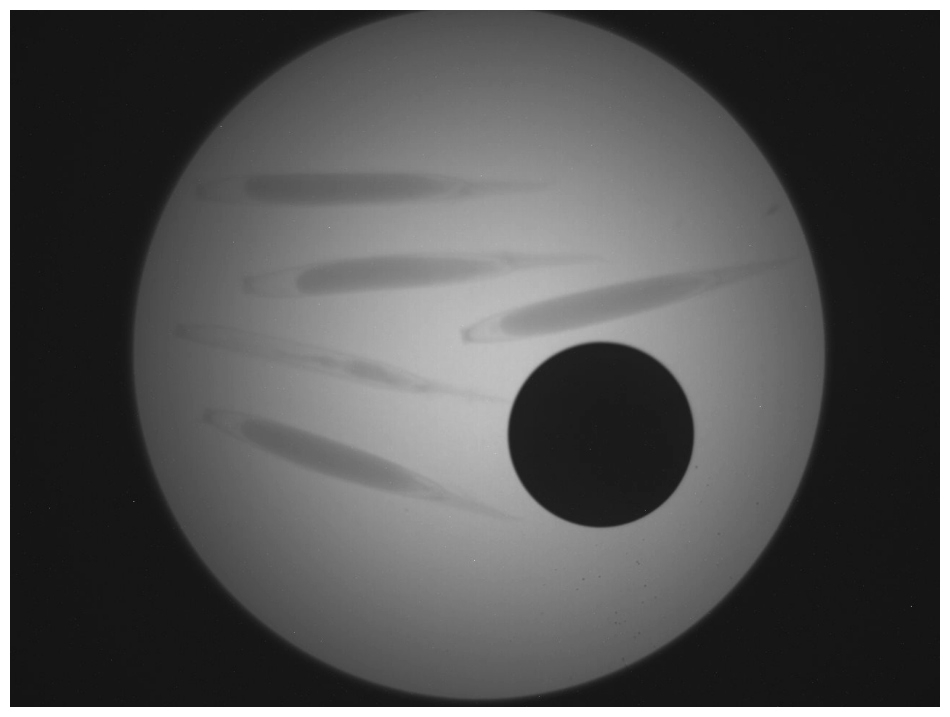

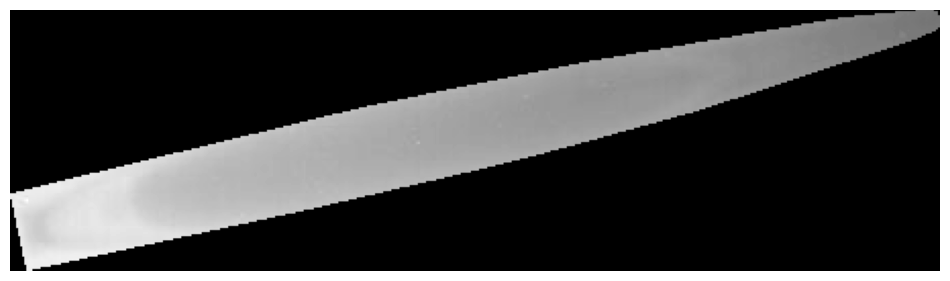

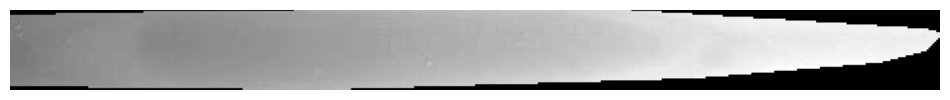

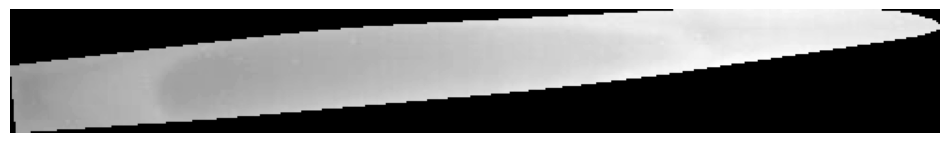

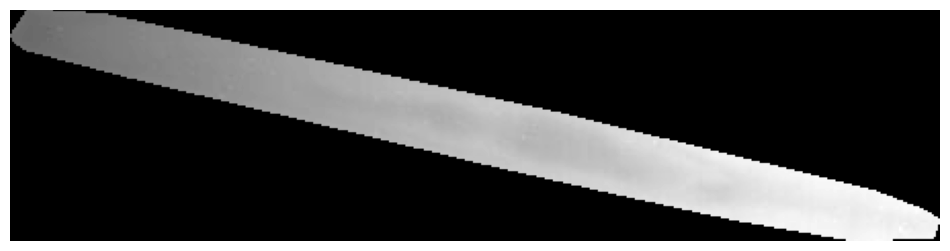

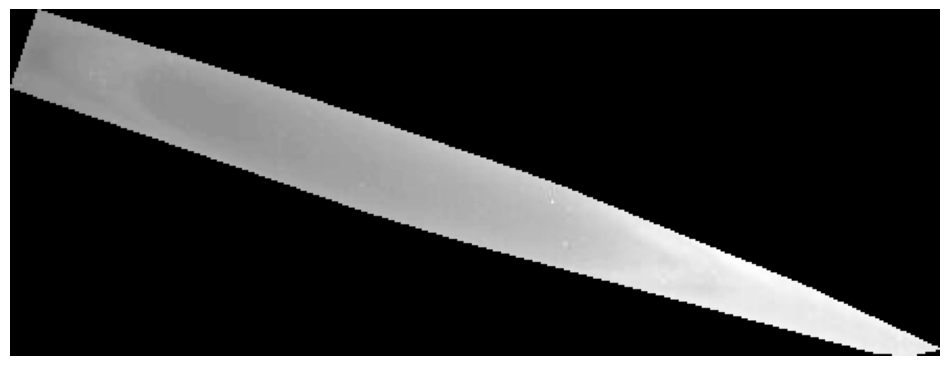

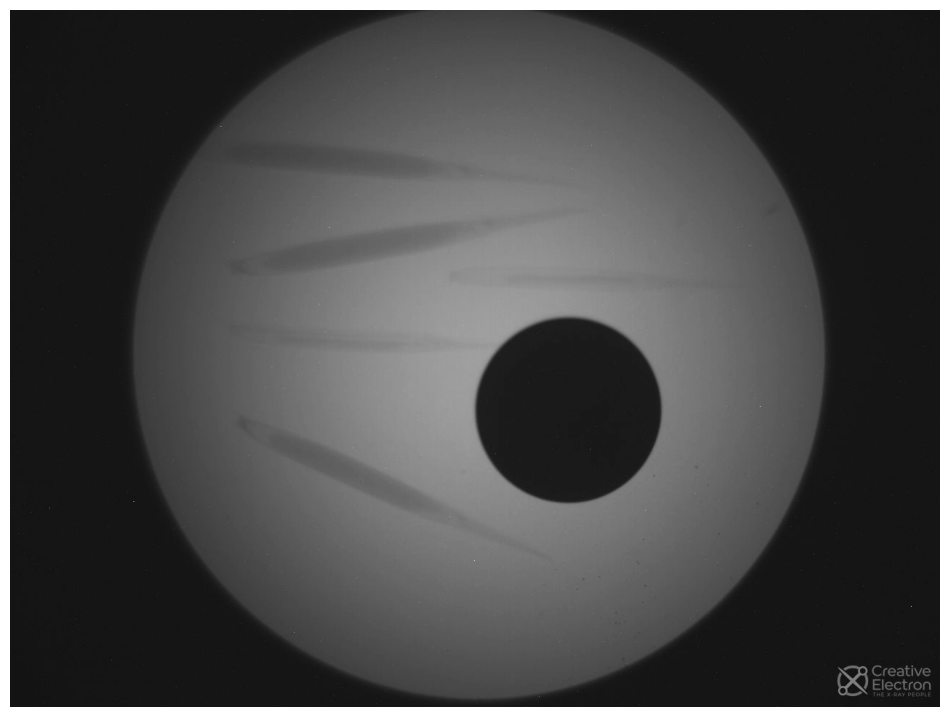

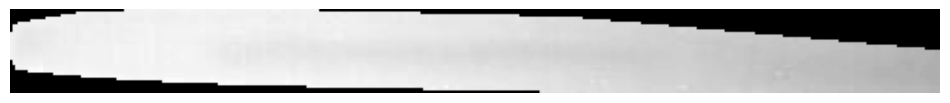

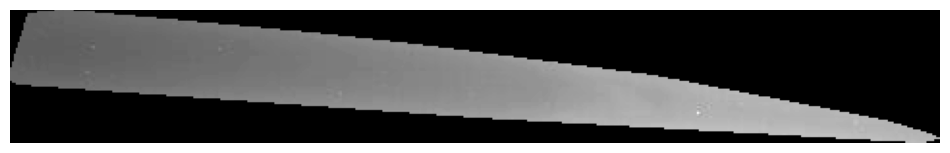

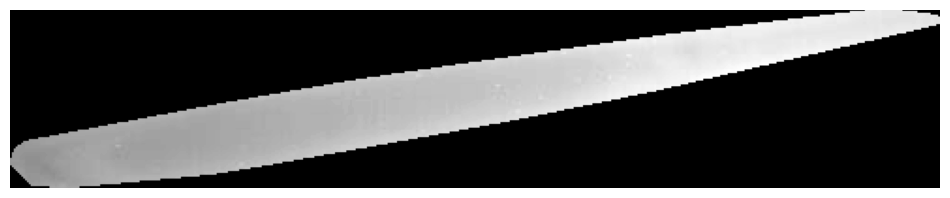

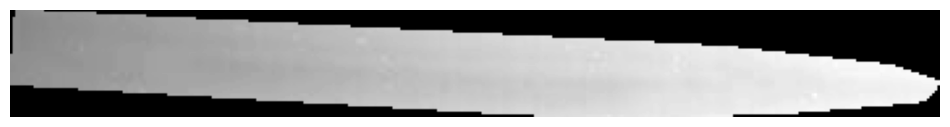

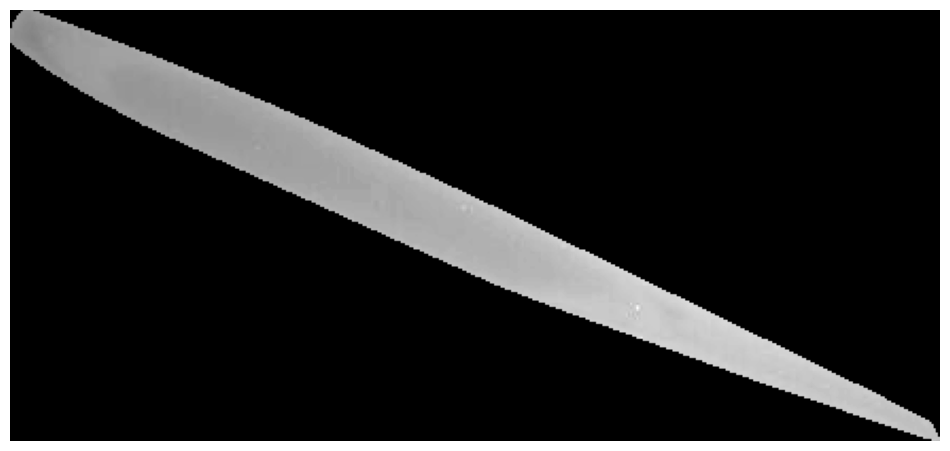

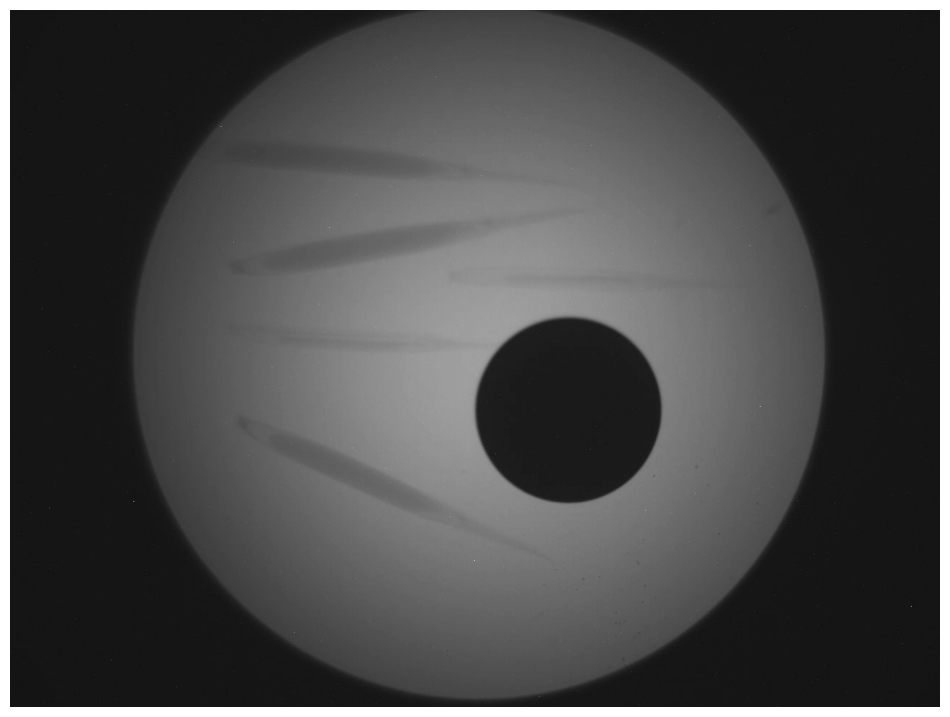

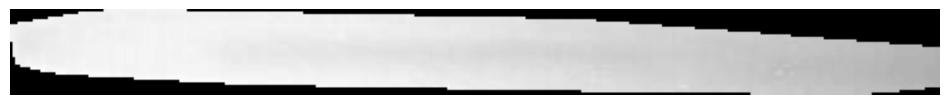

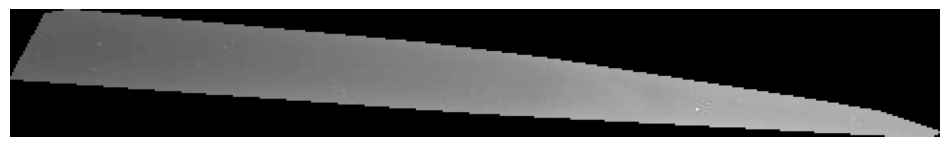

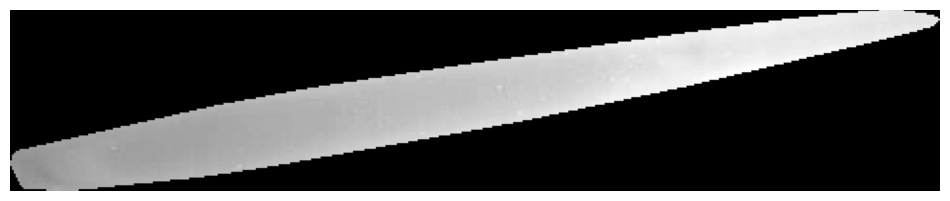

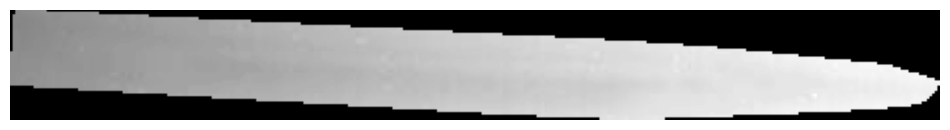

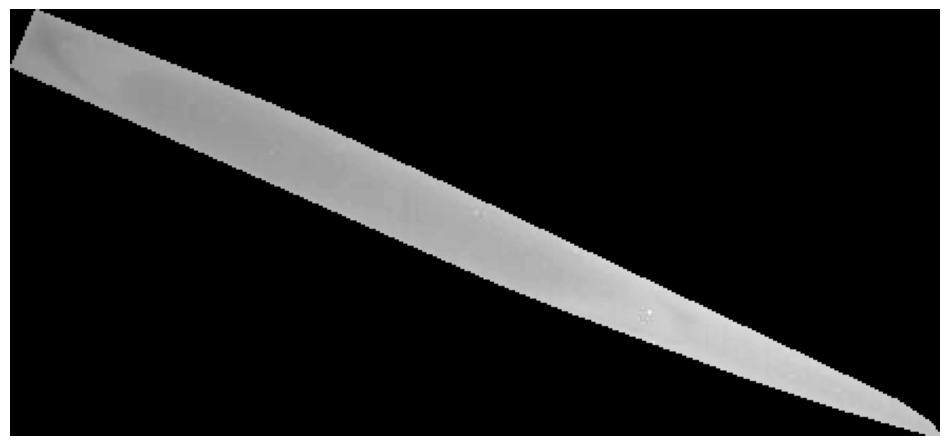

In [30]:
def segment_seeds(image_path, small_stop=20, big_start=32):
    orig, gray = get_gray_scale(image_path)
    mask = get_mask(gray)
    image = enhance_contrast(gray, mask)
    edges, circles = find_circles(mask)
    big, small = circles
    edges = expand_circle(edges, small, 0, small.radius + small_stop)
    edges = expand_circle(edges, big, big.radius - big_start, big.radius)
    edges = flood_fill(edges)
    image = threshold_otsu(image, mask)
    image = apply_mask(image, edges)
    image, labels = find_areas(image)
    seeds = join_head_body(image, image_path, labels)
    seeds = sort_seeds(seeds)
    one_up(gray)
    cutout_seeds(seeds, gray)


for path in PATHS:
    segment_seeds(path)
# segment_seeds(PATHS[-1])